**Goal:** Analyze baseline models fit.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

from datasets import load_dataset
from setfit import SetFitModel

In [2]:
langs = ["java", "python", "pharo"]

labels = {
    "java": ["summary", "Ownership", "Expand", "usage", "Pointer", "deprecation", "rational"],
    "python": ["Usage", "Parameters", "DevelopmentNotes", "Expand", "Summary"],
    "pharo": ["Keyimplementationpoints", "Example", "Responsibilities", "Classreferences", "Intent", "Keymessages", "Collaborators"]
}

### Load the baseline models:

In [3]:
java_model = SetFitModel.from_pretrained("NLBSE/nlbse25_java")
python_model = SetFitModel.from_pretrained("NLBSE/nlbse25_python")
pharo_model = SetFitModel.from_pretrained("NLBSE/nlbse25_pharo")

### Load and transform the data:

In [4]:
dataset = load_dataset("NLBSE/nlbse25-code-comment-classification")

In [5]:
java_df = []
python_df = []
pharo_df = []

lang = "java"
for s in ["train", "test"]:
	df = pd.DataFrame(dataset[f"{lang}_{s}"])
	labels_df = pd.DataFrame(df["labels"].tolist(), columns=labels[lang])
	df = pd.concat([df, labels_df], axis=1)
	java_df.append(df)
java_df = pd.concat(java_df).reset_index(drop=True)

lang = "python"
for s in ["train", "test"]:
	df = pd.DataFrame(dataset[f"{lang}_{s}"])
	labels_df = pd.DataFrame(df["labels"].tolist(), columns=labels[lang])
	df = pd.concat([df, labels_df], axis=1)
	python_df.append(df)
python_df = pd.concat(python_df).reset_index(drop=True)

lang = "pharo"
for s in ["train", "test"]:
	df = pd.DataFrame(dataset[f"{lang}_{s}"])
	labels_df = pd.DataFrame(df["labels"].tolist(), columns=labels[lang])
	df = pd.concat([df, labels_df], axis=1)
	pharo_df.append(df)
pharo_df = pd.concat(pharo_df).reset_index(drop=True)

### Analyze baseline models fit:

In [6]:
java_lbl_perc_df = java_df[["partition"] + labels["java"]].groupby("partition").mean()
python_lbl_perc_df = python_df[["partition"] + labels["python"]].groupby("partition").mean()
pharo_lbl_perc_df = pharo_df[["partition"] + labels["pharo"]].groupby("partition").mean()

In [7]:
stats.pearsonr(
	java_lbl_perc_df.iloc[[1]].values.reshape(-1),
	np.array([0.85085, 1.0, 0.374468, 0.862119, 0.827068, 0.692308, 0.209302])  # F1 reported for the baseline model
)


PearsonRResult(statistic=0.3560143793869595, pvalue=0.43317360902424795)

In [8]:
stats.pearsonr(
	python_lbl_perc_df.iloc[[1]].values.reshape(-1),
	np.array([0.717742, 0.803089, 0.325203, 0.553672, 0.615385])  # F1 reported for the baseline model
)

PearsonRResult(statistic=0.9592489765375041, pvalue=0.00981451861998819)

In [9]:
stats.pearsonr(
	pharo_lbl_perc_df.iloc[[1]].values.reshape(-1),
	np.array([0.643678, 0.887931, 0.596154, 0.285714, 0.741935, 0.731183, 	0.363636])  # F1 reported for the baseline model
)

PearsonRResult(statistic=0.8198541169372404, pvalue=0.02394757741925615)

**Insight:** For Python and Pharo, there is a (statistically significant) high correlation between the representation of the positive class and the F1 reported for the baseline model. For Java, it is undecidable.

In [10]:
java_preds_df = pd.DataFrame(java_model(java_df["combo"].tolist()).numpy(), columns=labels["java"])
python_preds_df = pd.DataFrame(python_model(python_df["combo"].tolist()).numpy(), columns=labels["python"])
pharo_preds_df = pd.DataFrame(pharo_model(pharo_df["combo"].tolist()).numpy(), columns=labels["pharo"])

In [11]:
def compute_metrics(y_true, y_pred, labels):
	scores = []

	for i in range(len(y_pred)):
		tp = sum([true == pred == 1 for (true, pred) in zip(y_true[i], y_pred[i])])
		tn = sum([true == pred == 0 for (true, pred) in zip(y_true[i], y_pred[i])])
		fp = sum([true == 0 and pred == 1 for (true, pred) in zip(y_true[i], y_pred[i])])
		fn = sum([true == 1 and pred == 0 for (true, pred) in zip(y_true[i], y_pred[i])])

		# Calculating error metrics
		precision = tp / (tp + fp)
		recall = tp / (tp + fn)
		f1 = (2*tp) / (2*tp + fp + fn)
		
		scores.append({
			"cat": labels[i],
			"precision": precision,
			"recall": recall,
			"f1": f1
		})
	
	return scores

In [12]:
y_true = java_df.loc[java_df["partition"] == 0, labels["java"]].to_numpy().T
y_pred = java_preds_df.loc[java_df["partition"] == 0].to_numpy().T

java_metrics_train_df = pd.DataFrame(compute_metrics(y_true, y_pred, labels["java"]))

y_true = java_df.loc[java_df["partition"] == 1, labels["java"]].to_numpy().T
y_pred = java_preds_df.loc[java_df["partition"] == 1].to_numpy().T

java_metrics_test_df = pd.DataFrame(compute_metrics(y_true, y_pred, labels["java"]))

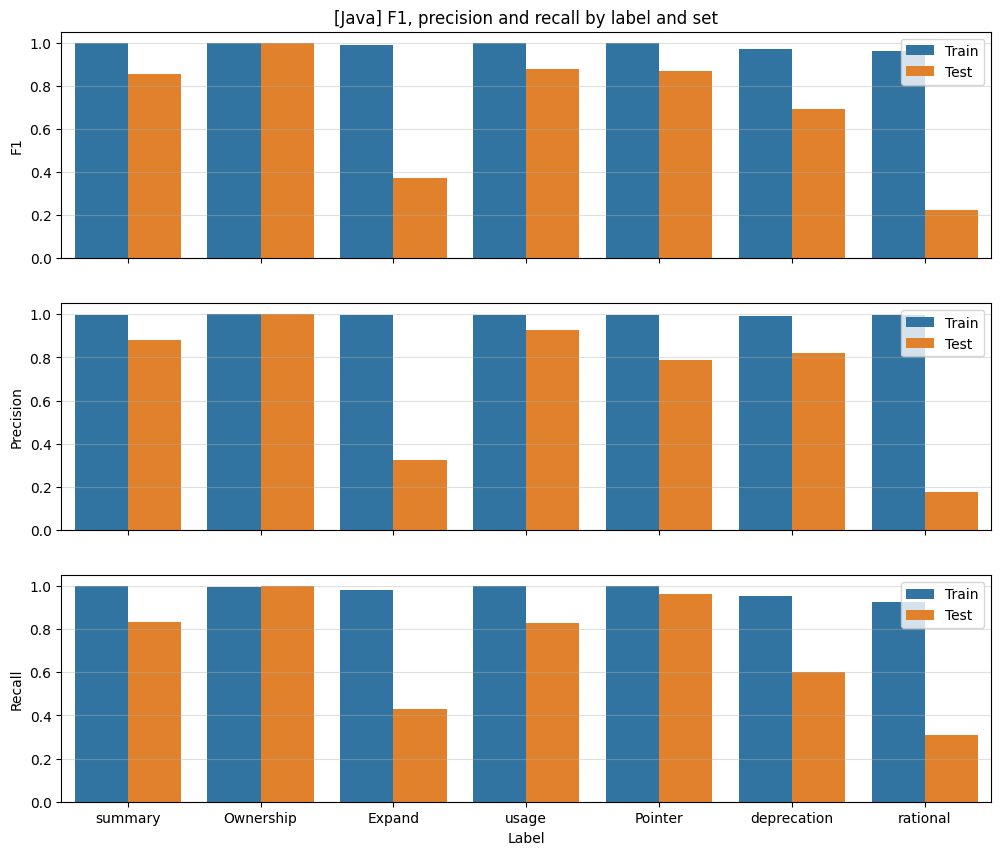

In [13]:
java_metrics_train_df["set"] = "Train"
java_metrics_test_df["set"] = "Test"
java_metrics_all_df = pd.concat([java_metrics_train_df, java_metrics_test_df])

fig, axes = plt.subplots(3, 1, sharex=True, figsize=(12, 10))

sns.barplot(data=java_metrics_all_df, x="cat", y="f1", hue="set", ax=axes[0])
axes[0].set_xlabel("Label")
axes[0].set_ylabel("F1")
axes[0].grid(axis="y", alpha=0.4)
axes[0].legend()

sns.barplot(data=java_metrics_all_df, x="cat", y="precision", hue="set", ax=axes[1])
axes[1].set_xlabel("Label")
axes[1].set_ylabel("Precision")
axes[1].grid(axis="y", alpha=0.4)
axes[1].legend()

sns.barplot(data=java_metrics_all_df, x="cat", y="recall", hue="set", ax=axes[2])
axes[2].set_xlabel("Label")
axes[2].set_ylabel("Recall")
axes[2].grid(axis="y", alpha=0.4)
axes[2].legend()

axes[0].set_title("[Java] F1, precision and recall by label and set")
plt.show()

In [14]:
y_true = python_df.loc[python_df["partition"] == 0, labels["python"]].to_numpy().T
y_pred = python_preds_df.loc[python_df["partition"] == 0].to_numpy().T

python_metrics_train_df = pd.DataFrame(compute_metrics(y_true, y_pred, labels["python"]))

y_true = python_df.loc[python_df["partition"] == 1, labels["python"]].to_numpy().T
y_pred = python_preds_df.loc[python_df["partition"] == 1].to_numpy().T

python_metrics_test_df = pd.DataFrame(compute_metrics(y_true, y_pred, labels["python"]))

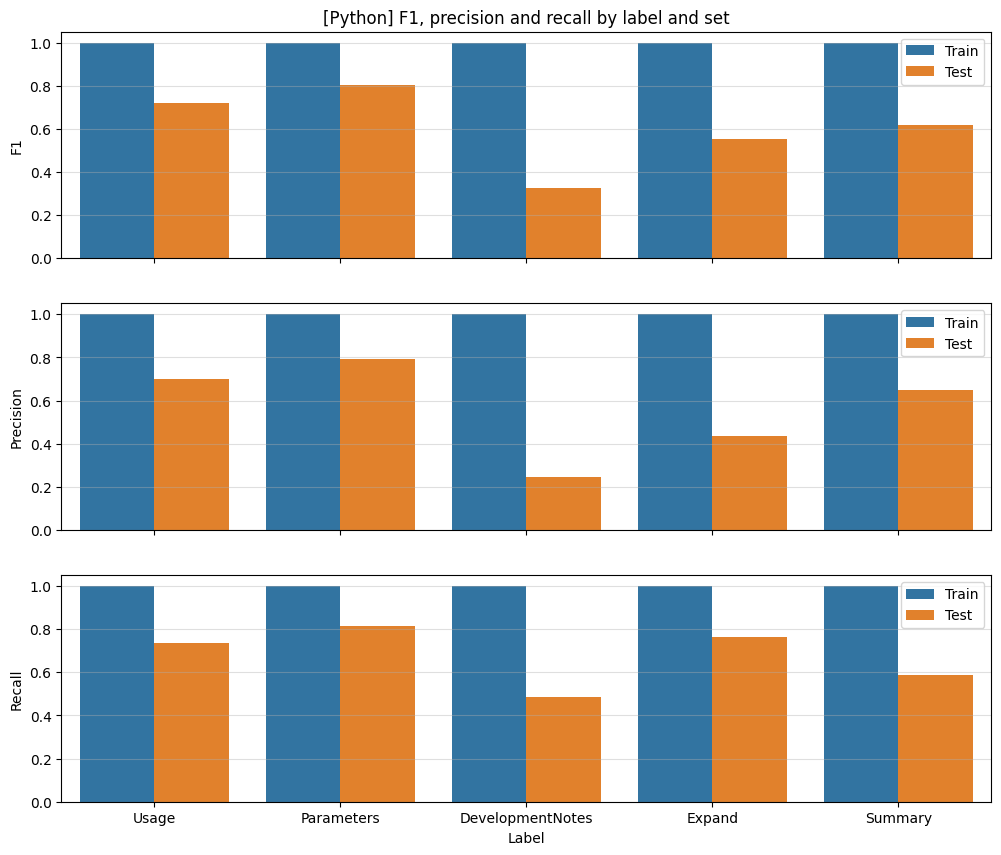

In [15]:
python_metrics_train_df["set"] = "Train"
python_metrics_test_df["set"] = "Test"
python_metrics_all_df = pd.concat([python_metrics_train_df, python_metrics_test_df])

fig, axes = plt.subplots(3, 1, sharex=True, figsize=(12, 10))

sns.barplot(data=python_metrics_all_df, x="cat", y="f1", hue="set", ax=axes[0])
axes[0].set_xlabel("Label")
axes[0].set_ylabel("F1")
axes[0].grid(axis="y", alpha=0.4)
axes[0].legend()

sns.barplot(data=python_metrics_all_df, x="cat", y="precision", hue="set", ax=axes[1])
axes[1].set_xlabel("Label")
axes[1].set_ylabel("Precision")
axes[1].grid(axis="y", alpha=0.4)
axes[1].legend()

sns.barplot(data=python_metrics_all_df, x="cat", y="recall", hue="set", ax=axes[2])
axes[2].set_xlabel("Label")
axes[2].set_ylabel("Recall")
axes[2].grid(axis="y", alpha=0.4)
axes[2].legend()

axes[0].set_title("[Python] F1, precision and recall by label and set")
plt.show()

In [16]:
y_true = pharo_df.loc[pharo_df["partition"] == 0, labels["pharo"]].to_numpy().T
y_pred = pharo_preds_df.loc[pharo_df["partition"] == 0].to_numpy().T

pharo_metrics_train_df = pd.DataFrame(compute_metrics(y_true, y_pred, labels["pharo"]))

y_true = pharo_df.loc[pharo_df["partition"] == 1, labels["pharo"]].to_numpy().T
y_pred = pharo_preds_df.loc[pharo_df["partition"] == 1].to_numpy().T

pharo_metrics_test_df = pd.DataFrame(compute_metrics(y_true, y_pred, labels["pharo"]))

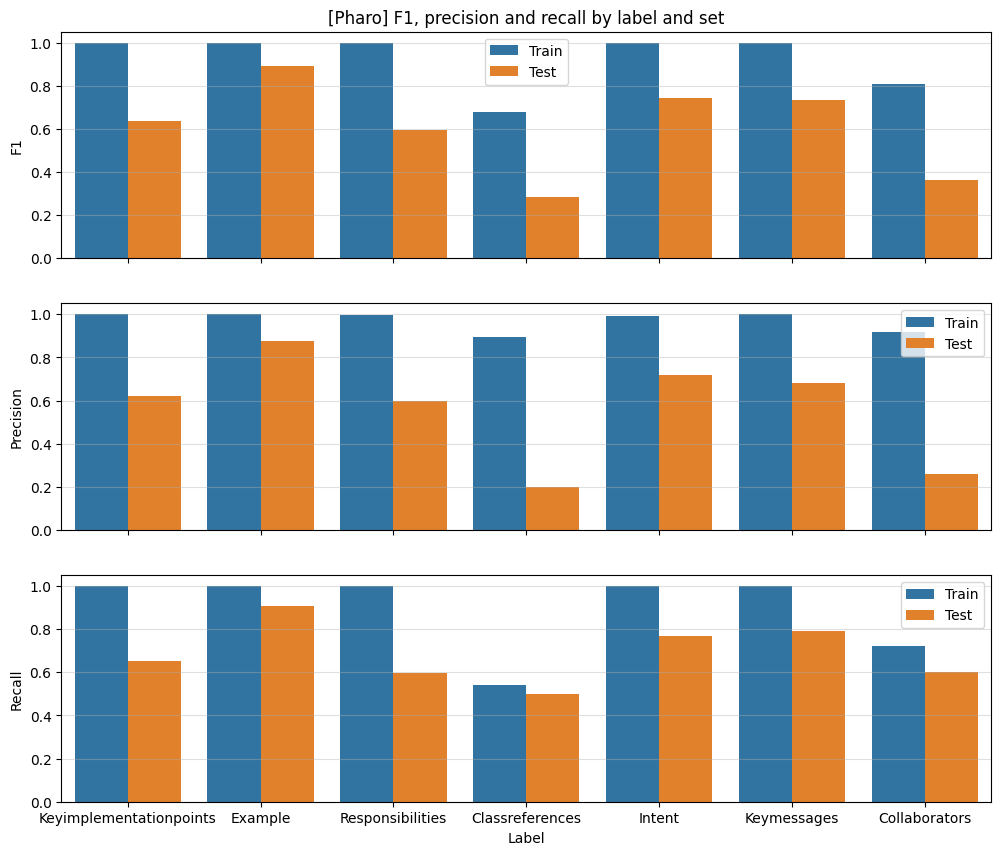

In [17]:
pharo_metrics_train_df["set"] = "Train"
pharo_metrics_test_df["set"] = "Test"
pharo_metrics_all_df = pd.concat([pharo_metrics_train_df, pharo_metrics_test_df])

fig, axes = plt.subplots(3, 1, sharex=True, figsize=(12, 10))

sns.barplot(data=pharo_metrics_all_df, x="cat", y="f1", hue="set", ax=axes[0])
axes[0].set_xlabel("Label")
axes[0].set_ylabel("F1")
axes[0].grid(axis="y", alpha=0.4)
axes[0].legend()

sns.barplot(data=pharo_metrics_all_df, x="cat", y="precision", hue="set", ax=axes[1])
axes[1].set_xlabel("Label")
axes[1].set_ylabel("Precision")
axes[1].grid(axis="y", alpha=0.4)
axes[1].legend()

sns.barplot(data=pharo_metrics_all_df, x="cat", y="recall", hue="set", ax=axes[2])
axes[2].set_xlabel("Label")
axes[2].set_ylabel("Recall")
axes[2].grid(axis="y", alpha=0.4)
axes[2].legend()

axes[0].set_title("[Pharo] F1, precision and recall by label and set")
plt.show()

**Insight:** There is a strong evidence of overfitting for most of the labels across the three languages.

### Inspect relationship between model performance and sentence length:

In [19]:
java_df["num_tokens"] = pd.Series(java_model.model_body.tokenizer(
    java_df["comment_sentence"].tolist(),
    add_special_tokens=False,
    return_length=True
)["length"])

python_df["num_tokens"] = pd.Series(python_model.model_body.tokenizer(
    python_df["comment_sentence"].tolist(),
    add_special_tokens=False,
    return_length=True
)["length"])

pharo_df["num_tokens"] = pd.Series(pharo_model.model_body.tokenizer(
    pharo_df["comment_sentence"].tolist(),
    add_special_tokens=False,
    return_length=True
)["length"])

Token indices sequence length is longer than the specified maximum sequence length for this model (140 > 128). Running this sequence through the model will result in indexing errors


In [20]:
num_buckets = 10

java_df.loc[java_df["partition"] == 0, "num_tokens_bucket"], bin_edges  = pd.qcut(java_df.loc[java_df["partition"] == 0, "num_tokens"], num_buckets, labels=False, retbins=True)
java_df.loc[java_df["partition"] == 1, "num_tokens_bucket"] = pd.cut(java_df.loc[java_df["partition"] == 1, "num_tokens"], bins=bin_edges, labels=False, include_lowest=True)

python_df.loc[python_df["partition"] == 0, "num_tokens_bucket"], bin_edges  = pd.qcut(python_df.loc[python_df["partition"] == 0, "num_tokens"], num_buckets, labels=False, retbins=True)
python_df.loc[python_df["partition"] == 1, "num_tokens_bucket"] = pd.cut(python_df.loc[python_df["partition"] == 1, "num_tokens"], bins=bin_edges, labels=False, include_lowest=True)

pharo_df.loc[pharo_df["partition"] == 0, "num_tokens_bucket"], bin_edges  = pd.qcut(pharo_df.loc[pharo_df["partition"] == 0, "num_tokens"], num_buckets, labels=False, retbins=True)
pharo_df.loc[pharo_df["partition"] == 1, "num_tokens_bucket"] = pd.cut(pharo_df.loc[pharo_df["partition"] == 1, "num_tokens"], bins=bin_edges, labels=False, include_lowest=True)

In [21]:
java_metrics_train = []
java_metrics_test = []

for b in range(0, 10):
    y_true = java_df.loc[(java_df["partition"] == 0) & (java_df["num_tokens_bucket"] == b), labels["java"]].to_numpy().T
    y_pred = java_preds_df.loc[(java_df["partition"] == 0) & (java_df["num_tokens_bucket"] == b)].to_numpy().T

    metrics_train = compute_metrics(y_true, y_pred, labels["java"])
    for m in metrics_train:
        m["bucket"] = b
    java_metrics_train += metrics_train

    y_true = java_df.loc[(java_df["partition"] == 1) & (java_df["num_tokens_bucket"] == b), labels["java"]].to_numpy().T
    y_pred = java_preds_df.loc[(java_df["partition"] == 1) & (java_df["num_tokens_bucket"] == b)].to_numpy().T

    metrics_test = compute_metrics(y_true, y_pred, labels["java"])
    for m in metrics_test:
        m["bucket"] = b
    java_metrics_test += metrics_test

/tmp/ipykernel_1523724/4222954384.py:11: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
/tmp/ipykernel_1523724/4222954384.py:12: RuntimeWarning: invalid value encountered in scalar divide
  recall = tp / (tp + fn)
/tmp/ipykernel_1523724/4222954384.py:13: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*tp) / (2*tp + fp + fn)
/tmp/ipykernel_1523724/4222954384.py:11: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
/tmp/ipykernel_1523724/4222954384.py:12: RuntimeWarning: invalid value encountered in scalar divide
  recall = tp / (tp + fn)
/tmp/ipykernel_1523724/4222954384.py:13: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*tp) / (2*tp + fp + fn)
/tmp/ipykernel_1523724/4222954384.py:11: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
/tmp/ipykernel_1523724/4222954384.py:12: RuntimeWarning: invalid value encountered in scalar di

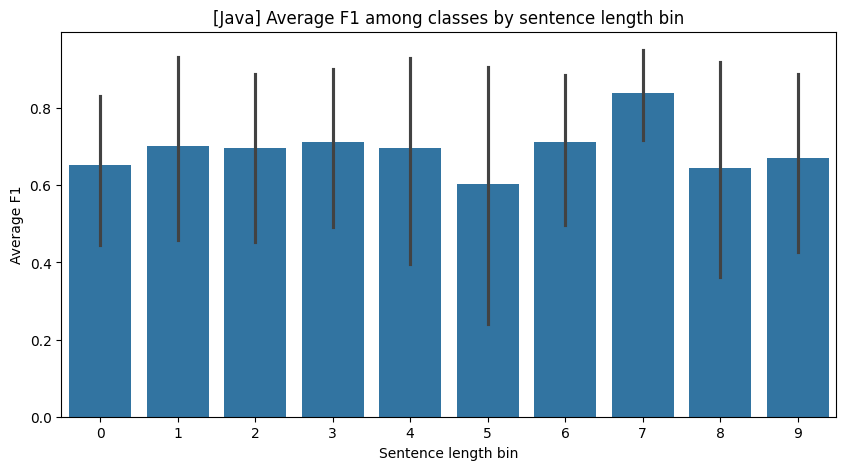

In [22]:
plt.figure(figsize=(10, 5))
sns.barplot(
    data=pd.DataFrame(java_metrics_test),
    x="bucket",
    y="f1",
    estimator="mean"
)
plt.title("[Java] Average F1 among classes by sentence length bin")
plt.xlabel("Sentence length bin")
plt.ylabel("Average F1")
plt.show()

In [23]:
python_metrics_train = []
python_metrics_test = []

for b in range(0, 10):
    y_true = python_df.loc[(python_df["partition"] == 0) & (python_df["num_tokens_bucket"] == b), labels["python"]].to_numpy().T
    y_pred = python_preds_df.loc[(python_df["partition"] == 0) & (python_df["num_tokens_bucket"] == b)].to_numpy().T

    metrics_train = compute_metrics(y_true, y_pred, labels["python"])
    for m in metrics_train:
        m["bucket"] = b
    python_metrics_train += metrics_train

    y_true = python_df.loc[(python_df["partition"] == 1) & (python_df["num_tokens_bucket"] == b), labels["python"]].to_numpy().T
    y_pred = python_preds_df.loc[(python_df["partition"] == 1) & (python_df["num_tokens_bucket"] == b)].to_numpy().T

    metrics_test = compute_metrics(y_true, y_pred, labels["python"])
    for m in metrics_test:
        m["bucket"] = b
    python_metrics_test += metrics_test

/tmp/ipykernel_1523724/4222954384.py:12: RuntimeWarning: invalid value encountered in scalar divide
  recall = tp / (tp + fn)


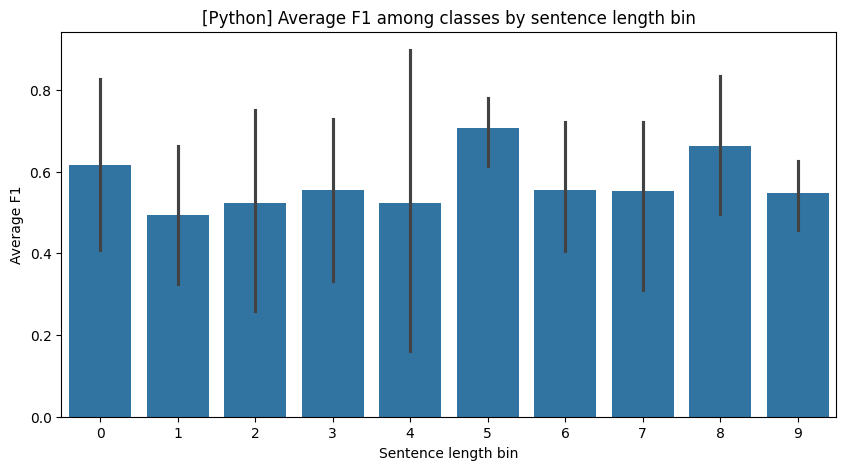

In [24]:
plt.figure(figsize=(10, 5))
sns.barplot(
    data=pd.DataFrame(python_metrics_test),
    x="bucket",
    y="f1",
    estimator="mean"
)
plt.title("[Python] Average F1 among classes by sentence length bin")
plt.xlabel("Sentence length bin")
plt.ylabel("Average F1")
plt.show()

In [25]:
pharo_metrics_train = []
pharo_metrics_test = []

for b in range(0, 10):
    y_true = pharo_df.loc[(pharo_df["partition"] == 0) & (pharo_df["num_tokens_bucket"] == b), labels["pharo"]].to_numpy().T
    y_pred = pharo_preds_df.loc[(pharo_df["partition"] == 0) & (pharo_df["num_tokens_bucket"] == b)].to_numpy().T

    metrics_train = compute_metrics(y_true, y_pred, labels["pharo"])
    for m in metrics_train:
        m["bucket"] = b
    pharo_metrics_train += metrics_train

    y_true = pharo_df.loc[(pharo_df["partition"] == 1) & (pharo_df["num_tokens_bucket"] == b), labels["pharo"]].to_numpy().T
    y_pred = pharo_preds_df.loc[(pharo_df["partition"] == 1) & (pharo_df["num_tokens_bucket"] == b)].to_numpy().T

    metrics_test = compute_metrics(y_true, y_pred, labels["pharo"])
    for m in metrics_test:
        m["bucket"] = b
    pharo_metrics_test += metrics_test

/tmp/ipykernel_1523724/4222954384.py:12: RuntimeWarning: invalid value encountered in scalar divide
  recall = tp / (tp + fn)
/tmp/ipykernel_1523724/4222954384.py:11: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
/tmp/ipykernel_1523724/4222954384.py:12: RuntimeWarning: invalid value encountered in scalar divide
  recall = tp / (tp + fn)
/tmp/ipykernel_1523724/4222954384.py:13: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*tp) / (2*tp + fp + fn)
/tmp/ipykernel_1523724/4222954384.py:11: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
/tmp/ipykernel_1523724/4222954384.py:12: RuntimeWarning: invalid value encountered in scalar divide
  recall = tp / (tp + fn)
/tmp/ipykernel_1523724/4222954384.py:11: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
/tmp/ipykernel_1523724/4222954384.py:13: RuntimeWarning: invalid value encountered in scalar divide
  

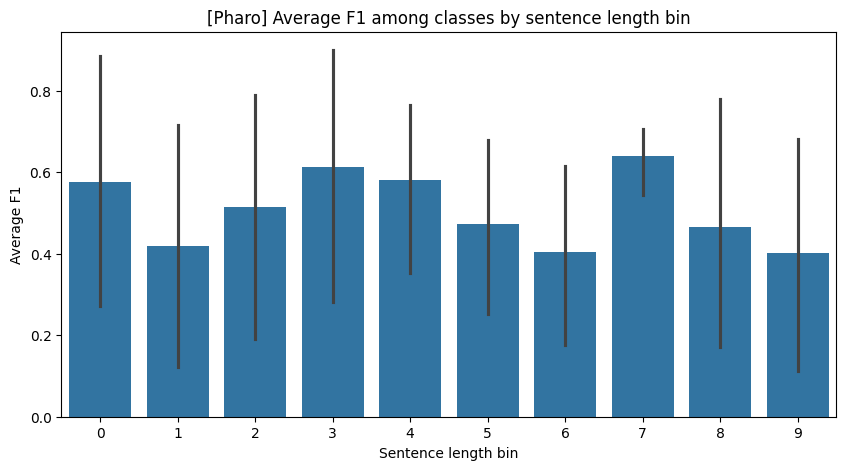

In [26]:
plt.figure(figsize=(10, 5))
sns.barplot(
    data=pd.DataFrame(pharo_metrics_test),
    x="bucket",
    y="f1",
    estimator="mean"
)
plt.title("[Pharo] Average F1 among classes by sentence length bin")
plt.xlabel("Sentence length bin")
plt.ylabel("Average F1")
plt.show()

**Insight:** There is not evidence that the baseline models perform worse on shorter sentences.